In [1]:
import cebra
from cebra import CEBRA
import cebra.models
import os
from scipy import stats
import tempfile
from pathlib import Path
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import rgb2hex
import pickle as pkl
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import sys
sys.path.append('../../..')
from dataset_load import data_load
from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import make_pipeline

import seaborn as sns

In [2]:
skipdates = ["220818", "220819"]
input_folder = "/sc-projects/sc-proj-cc15-ag-wenger-retune/data_kinematic_states_neural/"
VICON_FS = 200
variables_to_drop = ["ANIMAL_ID", "CONDITION", "RUN", "DATE", "EVENT", "ECOG_LEFT_fooof_a_knee", "ECOG_RIGHT_fooof_a_knee"]

In [3]:
data_dict = data_load(input_folder, variables_to_drop, skipdates)#, dataset_name="neukin_dataset_baseline_w1500ms")

x = data_dict["X_pd"]
y = data_dict["y_pd"]

No file found for 230425 NWE00161 02
No file found for 230425 NWE00161 08
No file found for 230425 NWE00160 04
No file found for 230425 NWE00160 03
No file found for 230425 NWE00164 21


In [4]:
def df_f1_score(true, pred, exclude_gait=False, average="weighted"):
    scores = []
    for t, p in zip(true, pred):
        if exclude_gait:
            p = p[np.where(t!=2, True, False)]
            t = t[np.where(t!=2, True, False)]
        scores.append(f1_score(t,p, average=average))
    return scores

In [5]:
permutations = {}
for i in range(11):
    with open(f"../neural_folds_cm/neural_predictions/predictions_neu_{i}_pd.pkl", "rb") as reference_file:
        permutations[i] = pkl.load(reference_file)

perms_df = pd.DataFrame.from_dict(permutations)
perms_df = perms_df.T
perms_df["f_score"] = df_f1_score(perms_df["true"], perms_df["prediction"], exclude_gait=False)
perms_df["f_score_no_gait"] = df_f1_score(perms_df["true"], perms_df["prediction"], exclude_gait=True)
perms_df['fold'] = perms_df.index

In [6]:
np.mean(perms_df["f_score"])

0.6214649799852162

In [7]:
scores_list = []


for i in range(11):
    with open(f"./fold_eval/permutations_fold_{i}.pkl", "rb") as input_file:
        knn_results = pkl.load(input_file)
        scores_d = {}
        scores_ng = {}
        for key, val in knn_results.items():
            
            true = val["true"]
            prediction =  val["prediction"]
            score = f1_score(true, prediction, average="weighted")
            scores_d[key] = score
            
            
        #df = pd.DataFrame(data=zip(knn_results.keys(), scores, scores_ng), columns=["feats", "f_score", "f_score_no_gait"])
        df = pd.DataFrame(scores_d, index=[i])
        scores_list.append(df)


In [8]:
scores_df = pd.concat(scores_list)

In [32]:
df = pd.merge(scores_df, perms_df[["f_score"]], left_index=True,  right_index=True , suffixes=["", "_ref"])
df_delta = - df.sub(df["f_score"], axis=0)
df_delta = df_delta.drop("f_score", axis=1)
means_df = pd.DataFrame(df_delta.mean(axis=0), index=df_delta.columns)
means_df.to_csv("../../../../ML_analysis/LDA_neural/mean_delta_knn_f1.csv")

In [35]:
means_df

,0
ECOG_LEFT_RawHjorth_Activity,0.014671
ECOG_LEFT_RawHjorth_Mobility,-0.002921
ECOG_LEFT_RawHjorth_Complexity,0.021688
ECOG_RIGHT_RawHjorth_Activity,0.006602
ECOG_RIGHT_RawHjorth_Mobility,0.012739
...,...
icoh_ECOG_RIGHT_to_ECOG_LEFT_mean_fband_high beta,-0.002367
icoh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_high beta,-0.000800
icoh_ECOG_RIGHT_to_ECOG_LEFT_mean_fband_high gamma,-0.000777
icoh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_high gamma,0.010126


In [24]:
#ord_idxs = np.argsort(df_delta.median(axis=0))[::-1]
ord_idxs = np.argsort(df_delta.mean(axis=0))[::-1]
ordered_feats = df_delta.columns[ord_idxs]

In [25]:
selected_feats = ordered_feats[:10]
selected_feats

Index(['ECOG_RIGHT_bursts_high gamma_amplitude_mean',
       'ECOG_RIGHT_RawHjorth_Complexity', 'ECOG_LEFT_RawHjorth_Complexity',
       'ECOG_LEFT_fft_high beta', 'ECOG_LEFT_RawHjorth_Activity',
       'ECOG_LEFT_Sharpwave_Max_prominence_range_5_30',
       'ECOG_RIGHT_RawHjorth_Mobility',
       'ECOG_LEFT_bursts_high beta_amplitude_max',
       'ECOG_LEFT_bursts_high beta_amplitude_mean',
       'icoh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_high gamma'],
      dtype='object')

In [26]:
feats_n = 5
cmap = plt.get_cmap('twilight')
feats_cmap = cmap(np.linspace(0.1, 1, 6))[:feats_n]
cmap_d = {k : v for k, v in zip(ordered_feats[:feats_n], feats_cmap)}

[-0.02  0.02  0.06  0.1 ]


(-0.015, 0.12)

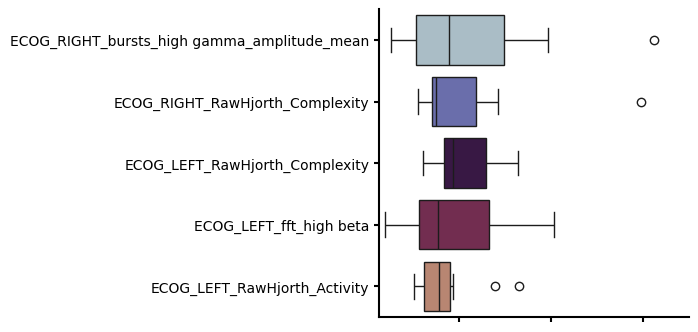

In [38]:
fig, ax = plt.subplots(figsize=(4,4))

selected_feats = ordered_feats[:feats_n]
sns.boxplot(data=df_delta[selected_feats], orient="h", order=selected_feats, palette= cmap_d)
#ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1])



ax.set_xticks(ticks=ax.get_xticks()[::2], labels=[], fontsize=15)
#ax.set_yticks(ticks=ax.get_yticks(), labels=[], fontsize=15)
print(ax.get_xticks())
ax.set_ylabel("")
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.tick_params(width=1.5)

ax.set_xlim(-0.015, 0.12)

#plt.savefig("./permutation_neural.png", transparent=True)
#plt.savefig("./permutation_neural.svg", transparent=True)

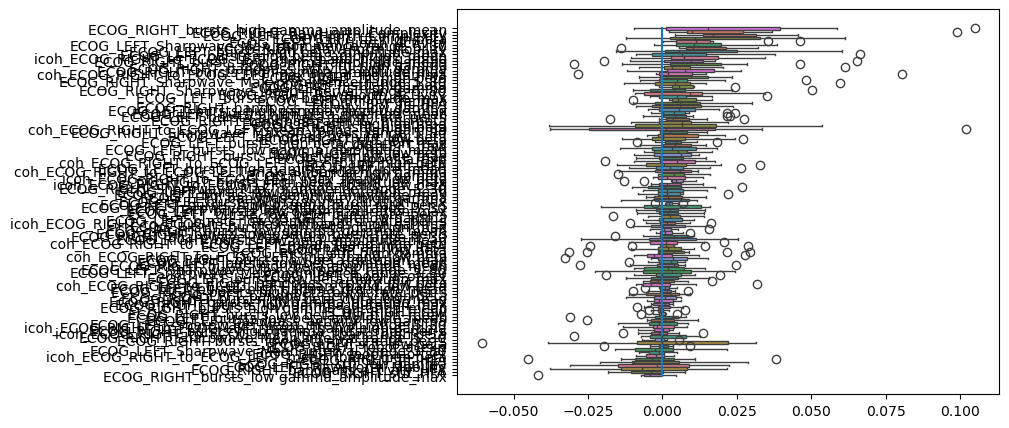

In [34]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df_delta[:15], orient="h", order=ordered_feats[:150])
ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1])

[-0.05  0.    0.05  0.1   0.15  0.2   0.25]


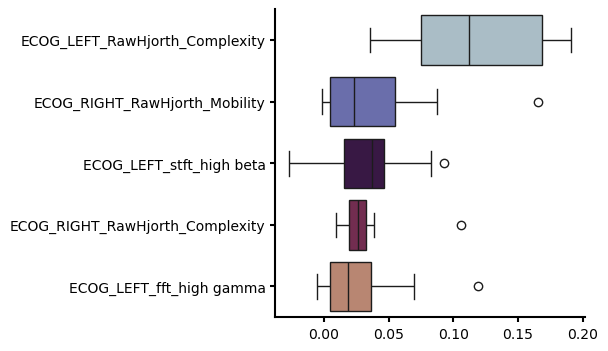

In [18]:
permutations = {}
for i in range(11):
    with open(f"../../CEBRA_train/new_run_fold/predictions_neu_pd/predictions_neu_{i}.pkl", "rb") as reference_file:
        permutations[i] = pkl.load(reference_file)

perms_df = pd.DataFrame.from_dict(permutations)
perms_df = perms_df.T
perms_df["f_score"] = df_f1_score(perms_df["true"], perms_df["prediction"], exclude_gait=False, average=None)
perms_df["f_score"] = perms_df["f_score"].apply(lambda x: x[0])
perms_df['fold'] = perms_df.index

scores_list = []

for i in range(11):
    with open(f"../../CEBRA_train/new_run_fold/knn_eval/fold_eval/permutations_fold_{i}.pkl", "rb") as input_file:
        knn_results = pkl.load(input_file)
        scores_d = {}
        scores_ng = {}
        for key, val in knn_results.items():
            
            true = val["true"]
            prediction =  val["prediction"]
            score = f1_score(true, prediction, average=None)[0]
            scores_d[key] = score
            
        #df = pd.DataFrame(data=zip(knn_results.keys(), scores, scores_ng), columns=["feats", "f_score", "f_score_no_gait"])
        df = pd.DataFrame(scores_d, index=[i])
        scores_list.append(df)
scores_df = pd.concat(scores_list)
df = pd.merge(scores_df, perms_df[["f_score"]], left_index=True,  right_index=True , suffixes=["", "_ref"])
df_delta = - df.sub(df["f_score"], axis=0)
df_delta = df_delta.drop("f_score", axis=1)
ord_idxs = np.argsort(df_delta.mean(axis=0))[::-1]
ordered_feats = df_delta.columns[ord_idxs]
selected_feats = ordered_feats[:10]
feats_n = 5
cmap = plt.get_cmap('twilight')
feats_cmap = cmap(np.linspace(0.1, 1, 6))[:feats_n]
cmap_d = {k : v for k, v in zip(ordered_feats[:feats_n], feats_cmap)}


fig, ax = plt.subplots(figsize=(4,4))

selected_feats = ordered_feats[:feats_n]
sns.boxplot(data=df_delta[selected_feats], orient="h", order=selected_feats, palette= cmap_d)
#ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1])



#ax.set_xticks(ticks=ax.get_xticks()[::2], labels=[], fontsize=15)
#ax.set_yticks(ticks=ax.get_yticks(), labels=[], fontsize=15)
print(ax.get_xticks())
ax.set_ylabel("")
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.tick_params(width=1.5)
plt.savefig("./permutation_neural_akinesia.svg", transparent=True)
#ax.set_xlim(-0.01, 0.14)

In [19]:
df

,ECOG_LEFT_RawHjorth_Activity,ECOG_LEFT_RawHjorth_Mobility,ECOG_LEFT_RawHjorth_Complexity,ECOG_RIGHT_RawHjorth_Activity,ECOG_RIGHT_RawHjorth_Mobility,ECOG_RIGHT_RawHjorth_Complexity,ECOG_LEFT_raw,ECOG_RIGHT_raw,ECOG_LEFT_bandpass_activity_low beta,ECOG_LEFT_bandpass_activity_high beta,...,coh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_high gamma,coh_ECOG_RIGHT_to_ECOG_LEFT_max_allfbands_high gamma,icoh_ECOG_RIGHT_to_ECOG_LEFT_mean_fband_low beta,icoh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_low beta,icoh_ECOG_RIGHT_to_ECOG_LEFT_mean_fband_high beta,icoh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_high beta,icoh_ECOG_RIGHT_to_ECOG_LEFT_mean_fband_high gamma,icoh_ECOG_RIGHT_to_ECOG_LEFT_max_fband_high gamma,icoh_ECOG_RIGHT_to_ECOG_LEFT_max_allfbands_high gamma,f_score
0,0.712518,0.782500,0.565545,0.732454,0.576452,0.731755,0.743705,0.735721,0.738530,0.747430,...,0.743350,0.737487,0.738914,0.745703,0.749030,0.742114,0.743112,0.740702,0.742283,0.742263
1,0.534723,0.608774,0.475434,0.580843,0.552428,0.549120,0.582849,0.587629,0.584883,0.586612,...,0.582364,0.580970,0.585486,0.584916,0.581442,0.583526,0.585700,0.582704,0.588121,0.587501
2,0.572967,0.566031,0.366482,0.525811,0.548626,0.526622,0.564015,0.554153,0.554858,0.568480,...,0.563354,0.569704,0.556271,0.571591,0.551658,0.566911,0.572753,0.561654,0.556535,0.557700
3,0.611357,0.602963,0.469470,0.604671,0.546227,0.527886,0.632836,0.627745,0.631015,0.625239,...,0.643608,0.636494,0.643439,0.615236,0.638893,0.628989,0.641308,0.628882,0.636383,0.633602
4,0.511092,0.473521,0.363936,0.486185,0.461994,0.513244,0.530520,0.529931,0.539644,0.538680,...,0.533822,0.532798,0.532705,0.535444,0.532216,0.529031,0.535960,0.528282,0.532973,0.536636
5,0.563850,0.563020,0.442256,0.558130,0.525936,0.532392,0.552241,0.549497,0.554051,0.556545,...,0.557112,0.551158,0.557997,0.549197,0.559188,0.546034,0.555099,0.544417,0.552079,0.554519
6,0.546277,0.578723,0.554480,0.593272,0.607957,0.590973,0.601569,0.602918,0.604801,0.608729,...,0.588229,0.604332,0.613970,0.596721,0.610713,0.583243,0.601567,0.604945,0.608895,0.607918
7,0.225533,0.229104,0.207577,0.245274,0.242887,0.233445,0.240626,0.238542,0.237608,0.236022,...,0.233467,0.240517,0.240108,0.238871,0.246509,0.251145,0.237613,0.234554,0.246196,0.243156
8,0.594638,0.582914,0.477665,0.544627,0.576808,0.547985,0.572749,0.572921,0.569421,0.573401,...,0.570637,0.575342,0.576730,0.576282,0.572952,0.574801,0.581762,0.575240,0.573523,0.575231
9,0.574111,0.550504,0.498799,0.576388,0.566665,0.552626,0.582987,0.587903,0.585922,0.588085,...,0.588911,0.586828,0.590204,0.590216,0.591055,0.589016,0.594884,0.586447,0.589196,0.586794


In [24]:

perms_df["f_score"].mean()

0.5682473175724186

In [25]:
perms_df["f_score"].std()

0.12130108581625694

In [20]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr


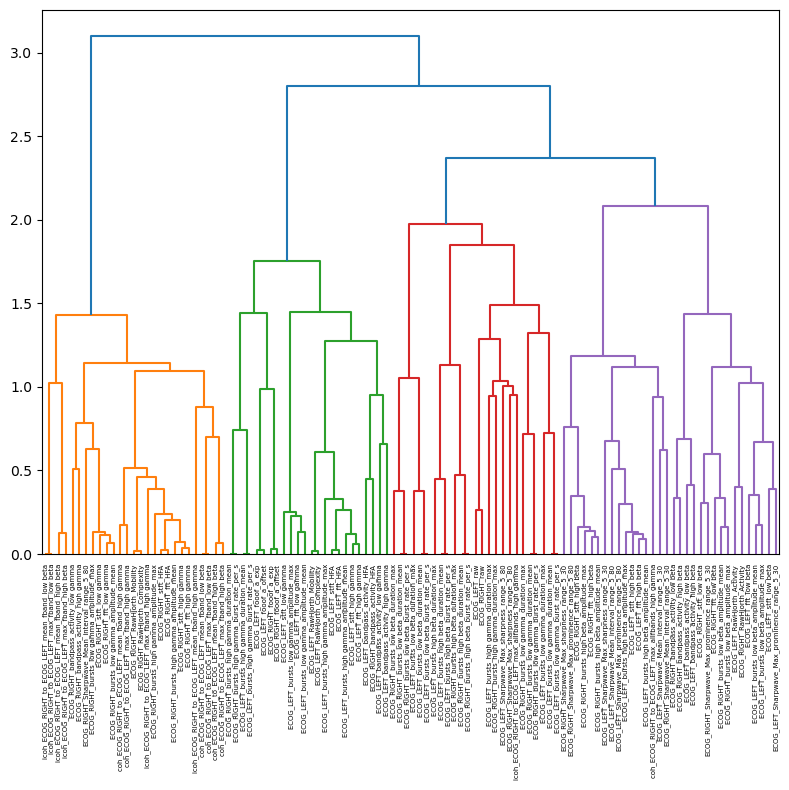

In [21]:
x = x.iloc[:, 36:]
fig, ax1 = plt.subplots(figsize=(8, 8))
corr = spearmanr(x).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=x.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))
_ = fig.tight_layout()

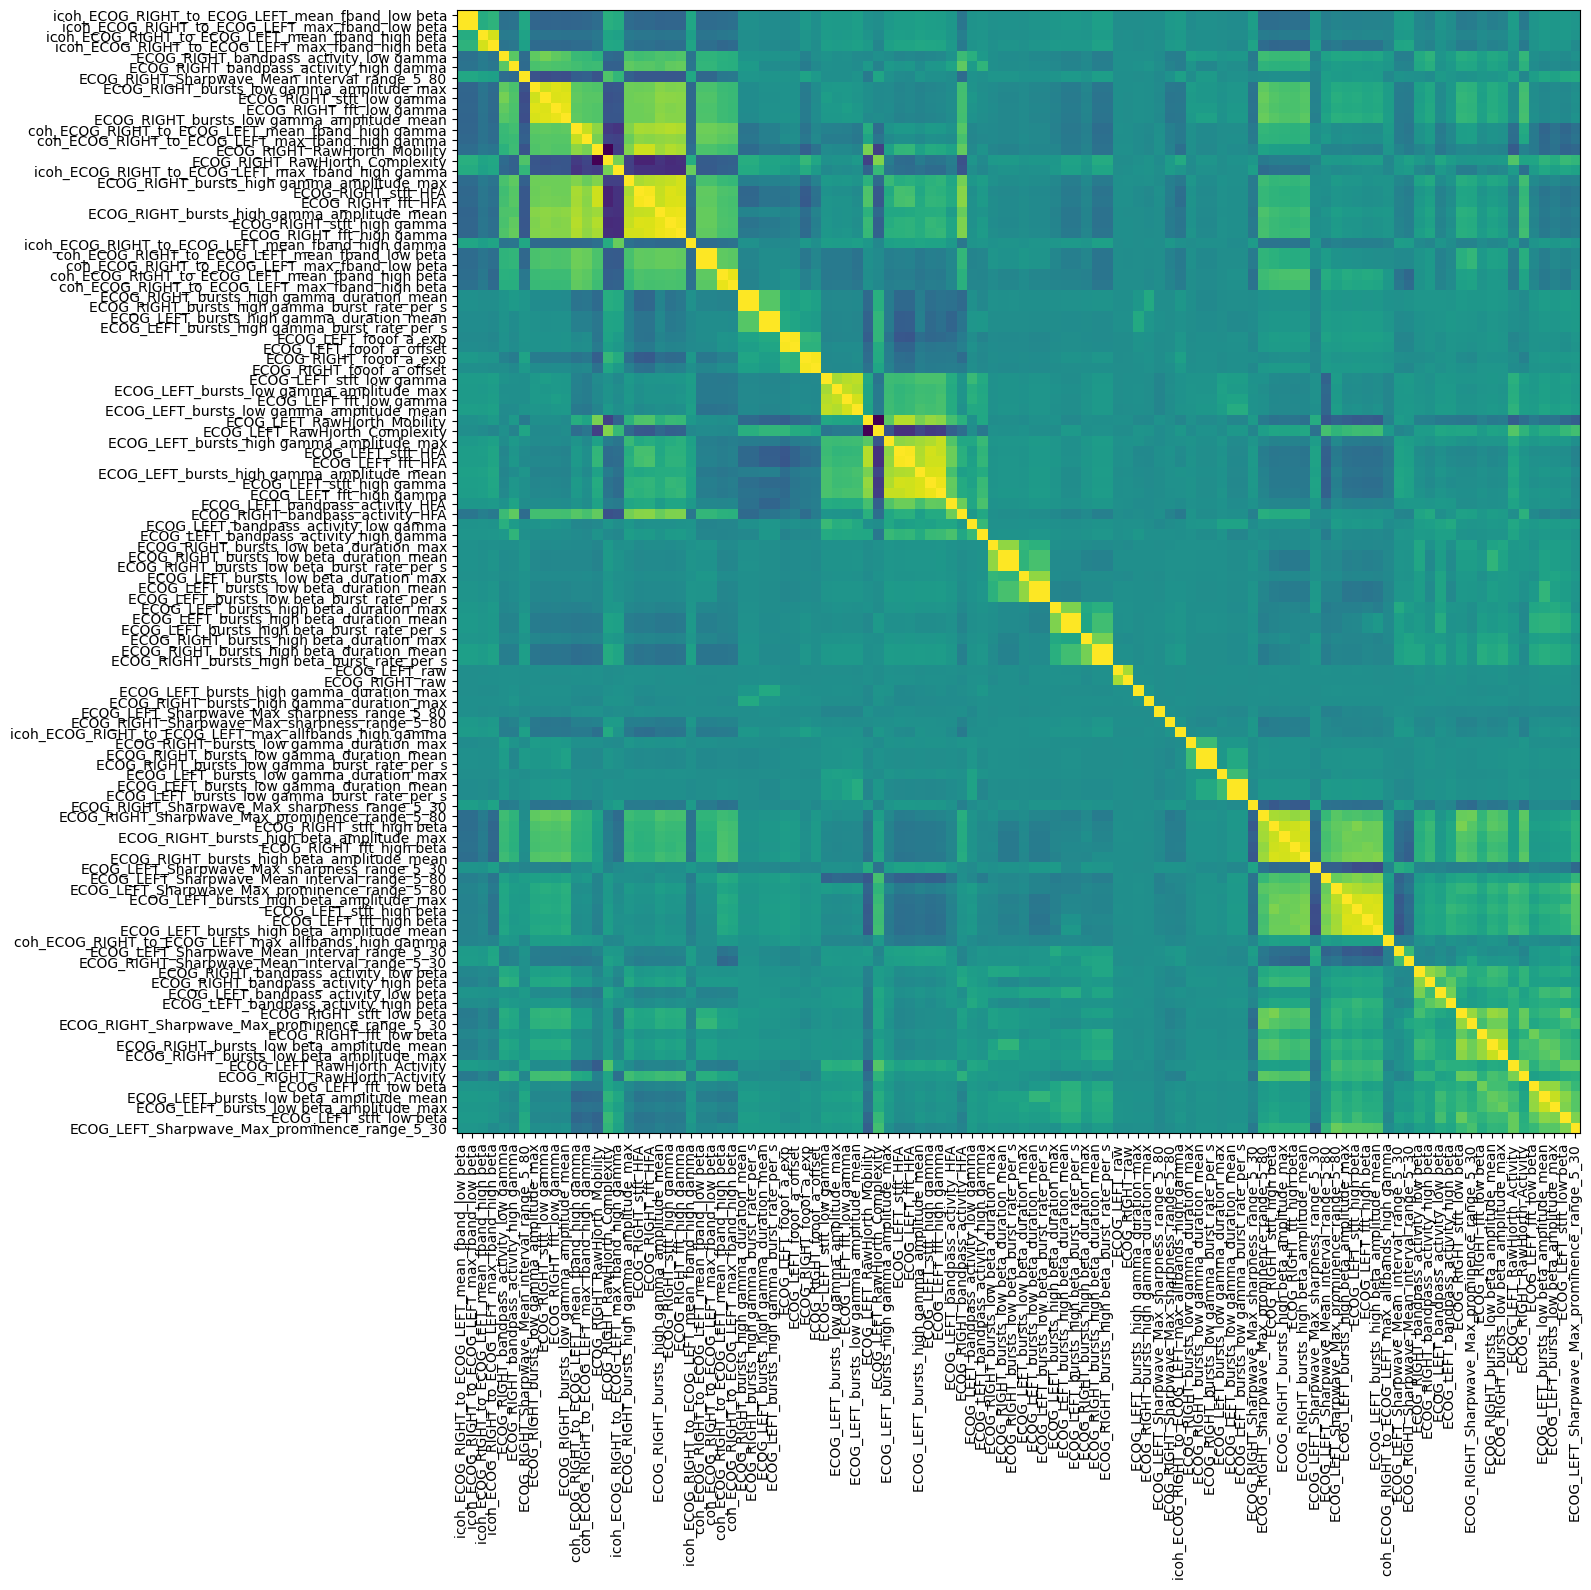

In [22]:

fig, ax2 = plt.subplots(figsize=(16, 16))
corr = spearmanr(x).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()
plt.savefig("./corr.png")